<a href="https://colab.research.google.com/github/Chiosas/Cats_for_GAN/blob/master/Cats_for_GAN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Initial Setup***

### ***Environment Setup***

In [0]:
import os
from pathlib import Path

In [0]:
dir_name = 'cats'
DATA_DIR = Path(f'data/{dir_name}')
MODEL_DIR = Path(f'model/{dir_name}')

In [0]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

FIRST_RUN = not os.path.exists(str(MODEL_DIR))

In [0]:
if not IN_COLAB:
    os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
    os.environ['CUDA_VISIBLE_DEVICES']='0'

if FIRST_RUN:
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(DATA_DIR, exist_ok=True)

In [0]:
if IN_COLAB and FIRST_RUN:
    !pip install -q --upgrade scikit-optimize
    !pip install -q -U --pre efficientnet
    !pip install -q -U --no-deps tensorflow-addons~=0.6
    # !pip install -q -U tensorflow-datasets
    # !pip install -q -U tensorflow_hub
    # !pip install -q -U keras-tuner
    # pass

### ***Kaggle Setup***

In [0]:
def setup_kaggle():
    x = !ls kaggle.json
    assert x == ['kaggle.json'], 'Upload kaggle.json'
    !mkdir /root/.kaggle
    !mv kaggle.json /root/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json

In [0]:
# Make sure you've uploaded 'kaggle.json' file into Colab
if IN_COLAB and FIRST_RUN:
    setup_kaggle()

In [0]:
import kaggle

In [0]:
if IN_COLAB and FIRST_RUN:
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files(
        dataset='spandan2/cats-faces-64x64-for-generative-models',
        path=DATA_DIR,
        unzip=True,
    )

### ***Importing Dependencies***

In [10]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

TensorFlow 2.x selected.


In [11]:
from imports import *

import tensorflow_addons as tfa
# import tensorflow_datasets as tfds
# import tensorflow_hub as hub
# import kerastuner as kt

import IPython.display as display

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [12]:
tf.__version__

'2.1.0-rc1'

In [0]:
if FIRST_RUN:
    exit()

In [0]:
%matplotlib inline

## ***Data Description***

### **Content**

![Jokes](https://cdn.dribbble.com/users/4491324/screenshots/8586953/shot-cropped-1574950787604.png)

The dataset contains 64x64 resized rgb images of cat faces.

*Format:* JPG images.

*Volume:* Total number of cats' images is almost 16,000.

We will use the dataset to build an image generative adversarial network (GAN) model.

###***Making Image Dataframes***

In [0]:
folder = 'cats'
labels = [label for label in list(os.listdir(DATA_DIR/folder)) if label[0].isalpha()]
cols = ['Label', 'Path', 'Image', 'Full_Path', 'Width', 'Height']

In [0]:
def read_dir(label, cols, folder):
    file_list = [name for name in list(os.listdir(DATA_DIR/folder/label.strip())) if name[0].isalnum()]
    image_df = pd.DataFrame(columns=cols)
    image_df['Image'] = file_list
    image_df['Label'] = label
    image_df['Path'] = str(DATA_DIR/folder/label.strip())
    image_df['Full_Path'] = image_df['Path'] + '/' + image_df['Image']
    
    return image_df

In [0]:
def make_image_df(labels, cols, set_path):
    image_df = pd.DataFrame(columns=cols)

    for label in labels:
        image_df = image_df.append(read_dir(label, cols, set_path), ignore_index=True)
    
    for row in range(image_df.shape[0]):
        img_dims = PIL.Image.open(image_df.iloc[row]['Full_Path']).size
        image_df.iloc[row]['Width'] = img_dims[0]
        image_df.iloc[row]['Height'] = img_dims[1]
    
    return image_df

In [0]:
raw_df = make_image_df(labels, cols, set_path=folder)

In [19]:
raw_df.head()

Label                 Path  ... Width Height
0  cats  data/cats/cats/cats  ...    64     64
1  cats  data/cats/cats/cats  ...    64     64
2  cats  data/cats/cats/cats  ...    64     64
3  cats  data/cats/cats/cats  ...    64     64
4  cats  data/cats/cats/cats  ...    64     64

[5 rows x 6 columns]

In [20]:
raw_df.tail()

Label                 Path  ... Width Height
15742  cats  data/cats/cats/cats  ...    64     64
15743  cats  data/cats/cats/cats  ...    64     64
15744  cats  data/cats/cats/cats  ...    64     64
15745  cats  data/cats/cats/cats  ...    64     64
15746  cats  data/cats/cats/cats  ...    64     64

[5 rows x 6 columns]

### ***Exploring Image Data***

In [21]:
df_dims = raw_df.shape
print(f'Total number of images in training dataset is {df_dims[0]}.')

Total number of images in training dataset is 15747.


In [22]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15747 entries, 0 to 15746
Data columns (total 6 columns):
Label        15747 non-null object
Path         15747 non-null object
Image        15747 non-null object
Full_Path    15747 non-null object
Width        15747 non-null object
Height       15747 non-null object
dtypes: object(6)
memory usage: 738.3+ KB


In [23]:
raw_df.describe(include='all')

Label                 Path  ...  Width Height
count   15747                15747  ...  15747  15747
unique      1                    1  ...      1      1
top      cats  data/cats/cats/cats  ...     64     64
freq    15747                15747  ...  15747  15747

[4 rows x 6 columns]

In [24]:
print(f"Image dimensions vary from {raw_df['Height'].min()} to {raw_df['Height'].max()} pixels in height.")
print(f"And from {raw_df['Width'].min()} to {raw_df['Width'].max()} pixels in width.")

Image dimensions vary from 64 to 64 pixels in height.
And from 64 to 64 pixels in width.


## ***Data Preparation***

### ***Data Split - Sample data***

In [0]:
_, sample_df = train_test_split(raw_df, test_size=0.1, random_state=10)

In [0]:
sample_df.reset_index(drop=True, inplace=True)

In [27]:
sample_df.shape

(1575, 6)

In [28]:
sample_df.head()

Label                 Path  ... Width Height
0  cats  data/cats/cats/cats  ...    64     64
1  cats  data/cats/cats/cats  ...    64     64
2  cats  data/cats/cats/cats  ...    64     64
3  cats  data/cats/cats/cats  ...    64     64
4  cats  data/cats/cats/cats  ...    64     64

[5 rows x 6 columns]

### ***Dataset Creation***

In [0]:
def image_parse(filename, img_dims):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, img_dims)
    image = image * 2 - 1
    return image

In [0]:
def prepare_ds(
    df,
    x,
    batch_size,
    parse_fn,
    prefetch=1,
    shuffle=False,
    num_parallel_calls=1,
):
    filenames = np.array([f"{getattr(row, x)}" for row in df.itertuples()])
    dataset_length = len(filenames)

    parse_fn = partial(image_parse, img_dims=(IMG_SIZE, IMG_SIZE))
    image_ds = (
        tf.data.Dataset.from_tensor_slices(filenames)
        .map(parse_fn, num_parallel_calls=num_parallel_calls)
     )

    if shuffle:
        image_ds = image_ds.shuffle(dataset_length)

    image_ds = image_ds.batch(batch_size, drop_remainder=True)
    if prefetch:
        image_ds = image_ds.prefetch(prefetch)
    return image_ds, dataset_length, batch_size

In [0]:
image_path_col = 'Full_Path'

IMG_SIZE = 64
BATCH_SIZE = 64

In [0]:
sample_dataset, sample_dataset_length, sample_batch_size = prepare_ds(
    df=sample_df,
    x=image_path_col,
    batch_size=BATCH_SIZE,
    parse_fn=image_parse,
    shuffle=True,
    prefetch=1,
    num_parallel_calls=-1,
)

In [33]:
sample_dataset.element_spec

TensorSpec(shape=(64, 64, 64, 3), dtype=tf.float32, name=None)

In [0]:
def plot_dataset(dataset, rows, cols):
    _, ax = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    for i, x in enumerate(dataset.take(rows * cols)):
        ax[i // cols, i % cols].axis('off')
        ax[i // cols, i % cols].imshow((x[0] + 1) / 2)

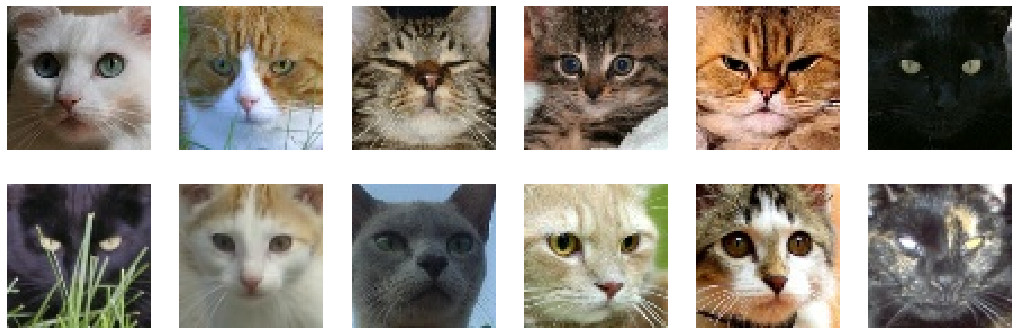

In [35]:
plot_dataset(sample_dataset, 2, 6)

## ***Building Model***

### ***GAN (Generative Adversarial Networks)***

In [0]:
CODINGS_SIZE = 512
IMG_CHANNELS = 3

image_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
dropout = 0.2
gener_lr = 1e-3
discr_lr = 1e-4

EPOCHS = 100

In [37]:
gener_layers = [
    tf.keras.layers.Dense(4 * 4 * 1024, input_shape=[CODINGS_SIZE]),
    tf.keras.layers.Reshape([4, 4, 1024]),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Conv2DTranspose(
        512,
        kernel_size=5,
        strides=2,
        padding='SAME',
        activation=tf.keras.activations.selu,
        kernel_initializer=tf.keras.initializers.lecun_uniform(),
    ),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Conv2DTranspose(
        256,
        kernel_size=5,
        strides=2,
        padding='SAME',
        activation=tf.keras.activations.selu,
        kernel_initializer=tf.keras.initializers.lecun_uniform(),
    ),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Conv2DTranspose(
        128,
        kernel_size=5,
        strides=2,
        padding='SAME',
        activation=tf.keras.activations.selu,
        kernel_initializer=tf.keras.initializers.lecun_uniform(),
    ),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Conv2DTranspose(
        IMG_CHANNELS, kernel_size=5, strides=2, padding='SAME', activation='tanh',
    ),
]

generator = tf.keras.models.Sequential(gener_layers)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             8404992   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 1024)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 1024)        4096      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         13107712  
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 256)       3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 256)       1

In [38]:
discr_layers = [
    tf.keras.layers.Conv2D(
        128,
        kernel_size=5,
        strides=2,
        padding='SAME',
        input_shape=image_shape,
        activation=tf.keras.layers.LeakyReLU(0.2),
        kernel_initializer=tf.keras.initializers.he_uniform(),
    ),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Conv2D(
        256,
        kernel_size=5,
        strides=2,
        padding='SAME',
        activation=tf.keras.layers.LeakyReLU(0.2),
        kernel_initializer=tf.keras.initializers.he_uniform(),
    ),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Conv2D(
        512,
        kernel_size=5,
        strides=2,
        padding='SAME',
        activation=tf.keras.layers.LeakyReLU(0.2),
        kernel_initializer=tf.keras.initializers.he_uniform(),
    ),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Conv2D(
        1024,
        kernel_size=5,
        strides=2,
        padding='SAME',
        activation=tf.keras.layers.LeakyReLU(0.2),
        kernel_initializer=tf.keras.initializers.he_uniform(),
    ),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation=keras.activations.sigmoid),
]

discriminator = tf.keras.models.Sequential(discr_layers)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       9728      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 512)        

In [39]:
gan = tf.keras.models.Sequential([generator, discriminator])
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 3)         25626371  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 17238785  
Total params: 42,865,156
Trainable params: 42,857,476
Non-trainable params: 7,680
_________________________________________________________________


In [0]:
discriminator.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.RMSprop(discr_lr)
)
discriminator.trainable = False

gan.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(gener_lr, beta_1=0.5)
)

In [0]:
def train_gan(gan, dataset, batch_size, codings_size, epochs=25):
    start = time.time()
    
    steps_per_epoch = 5
    epochs = math.ceil(epochs // steps_per_epoch)

    generator, discriminator = gan.layers

    for epoch in range(epochs):
        epoch_start = time.time()

        for step in range(steps_per_epoch):
            for train_batch in dataset:
                # phase 1 - training the discriminator
                noise = tf.random.normal(shape=[batch_size, codings_size])
                generated_images = generator(noise)
                fake_and_real_data = tf.concat([generated_images, train_batch], axis=0)
                fake_and_real_labels = tf.constant([[0.0]] * batch_size + [[1.0]] * batch_size)
                discriminator.trainable = True
                discriminator.train_on_batch(fake_and_real_data, fake_and_real_labels)
                # phase 2 - training the generator
                noise = tf.random.normal(shape=[batch_size, codings_size])
                noise_labels = tf.constant([[1.0]] * batch_size)
                discriminator.trainable = False
                gan.train_on_batch(noise, noise_labels)
            print('.', end='')

        # display.clear_output(wait=True)
        # display.display(plot_images(generated_images, 2, 6))
        epoch_end = time.time()
        print(f'\nTrain step: {(epoch + 1) * steps_per_epoch}')
        plot_images(generated_images, 2, 6)
        print(f'Last cycle time: {epoch_end - epoch_start:.1f}')

    end = time.time()
    print(f'Total time: {end - start:.1f}')

In [0]:
def plot_images(images, rows, cols):
    _, ax = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    for i, x in enumerate(images[:rows * cols]):
        ax[i // cols, i % cols].axis('off')
        ax[i // cols, i % cols].imshow((x + 1) / 2)
    plt.show()

.....
Train step: 5


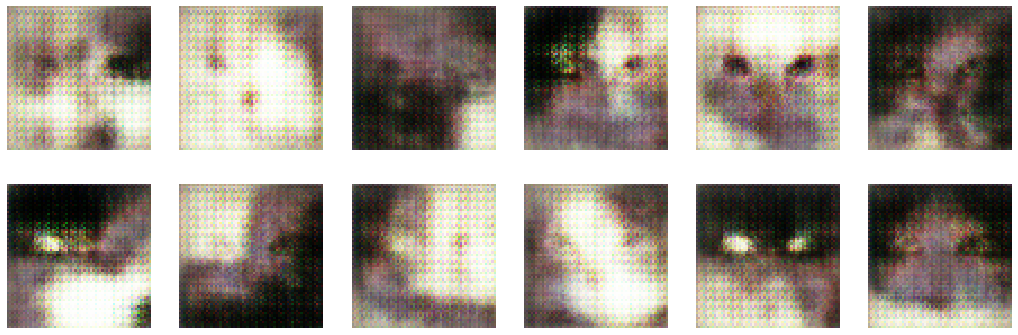

Last cycle time: 38.7
.....
Train step: 10


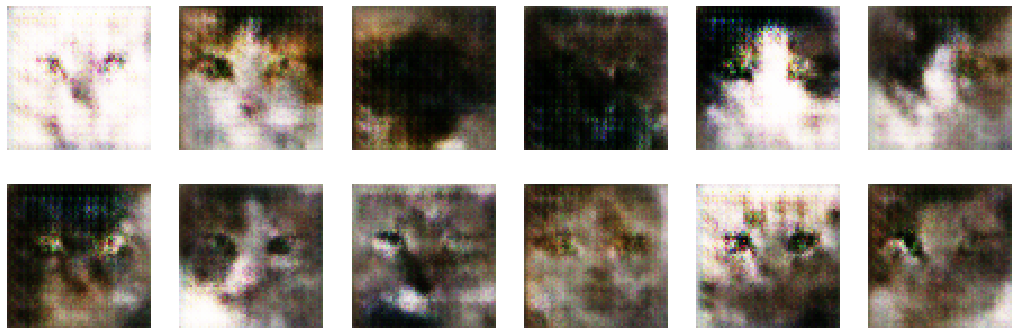

Last cycle time: 30.2
.....
Train step: 15


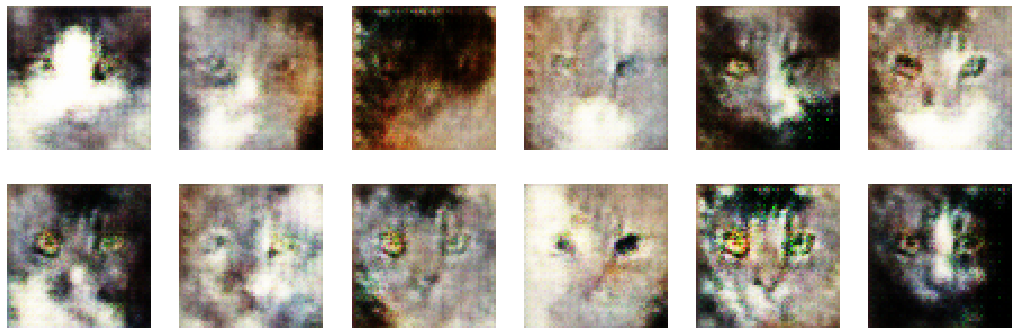

Last cycle time: 30.3
.....
Train step: 20


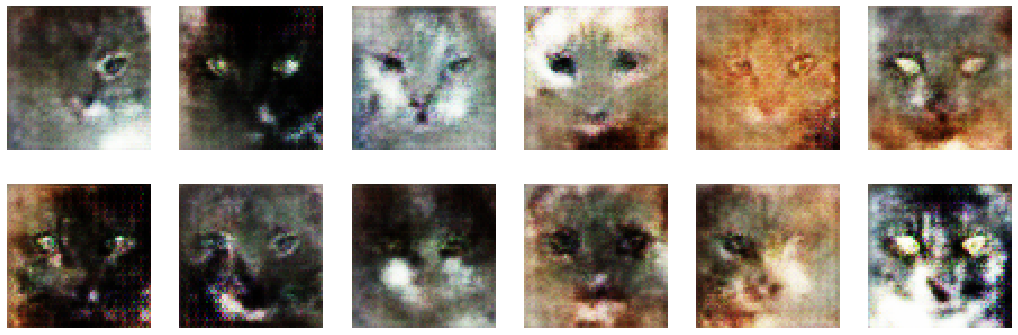

Last cycle time: 30.3
.....
Train step: 25


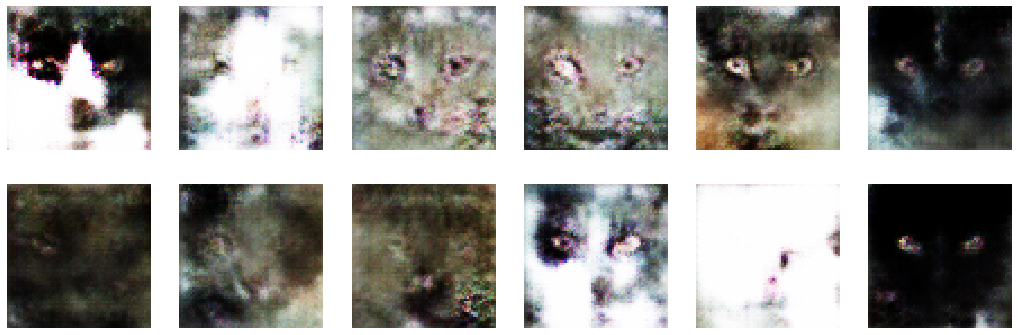

Last cycle time: 30.3
.....
Train step: 30


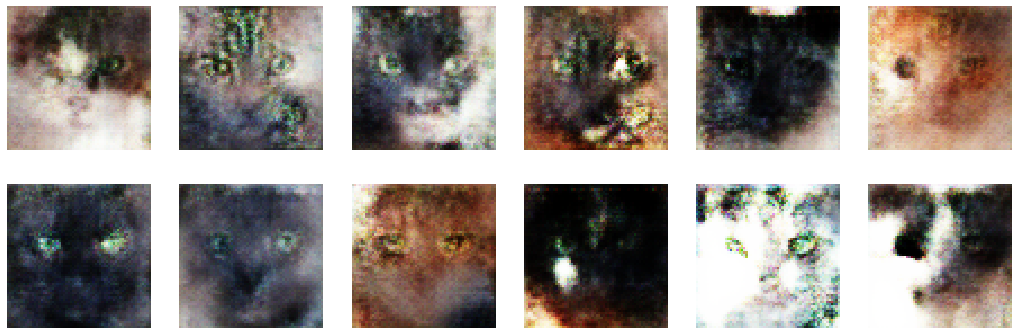

Last cycle time: 30.4
.....
Train step: 35


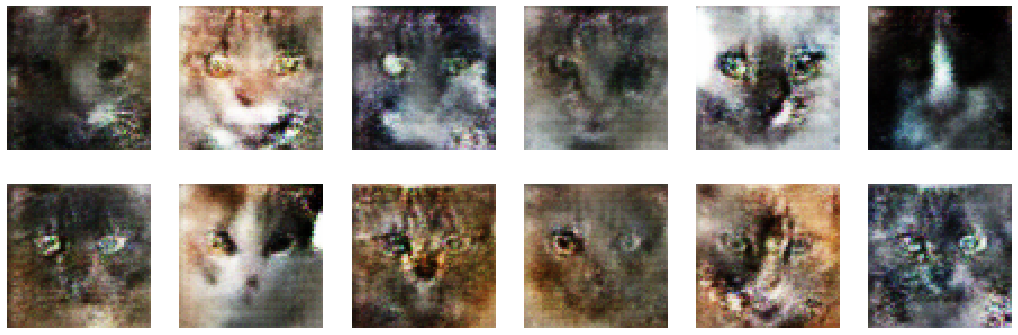

Last cycle time: 30.2
.....
Train step: 40


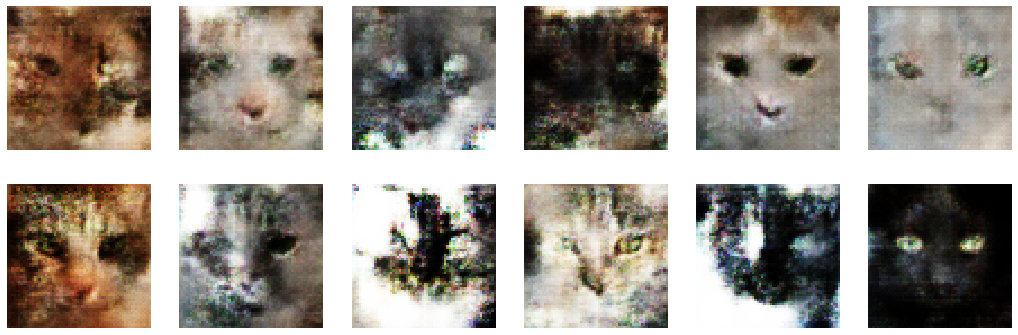

Last cycle time: 30.2
.....
Train step: 45


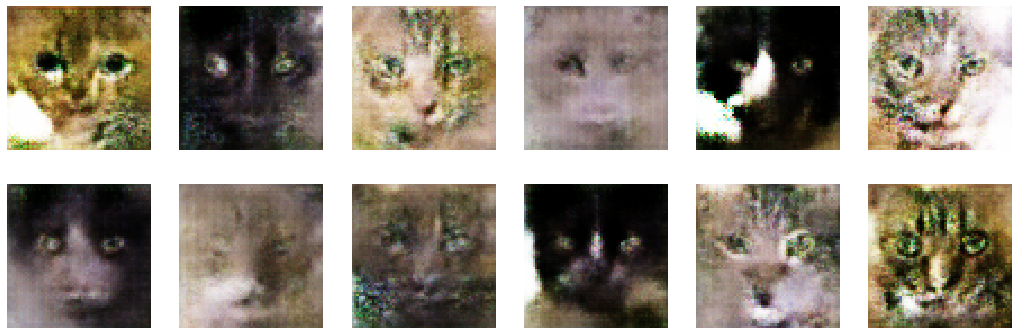

Last cycle time: 30.2
.....
Train step: 50


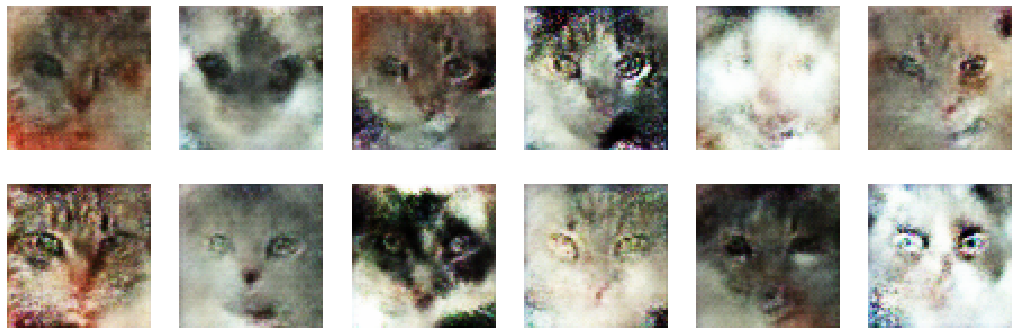

Last cycle time: 30.3
.....
Train step: 55


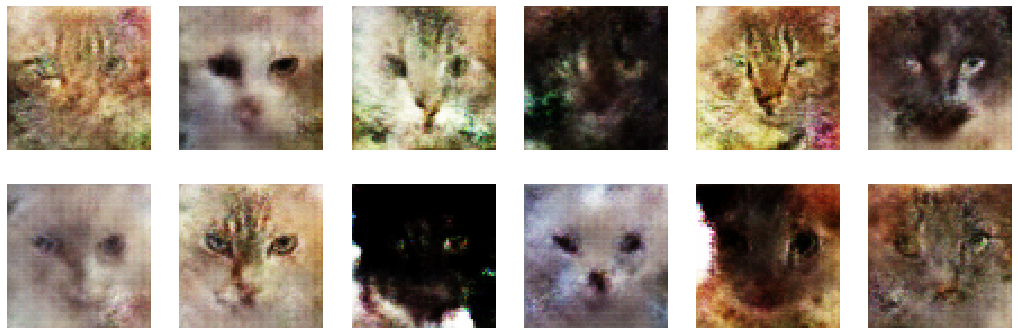

Last cycle time: 30.2
.....
Train step: 60


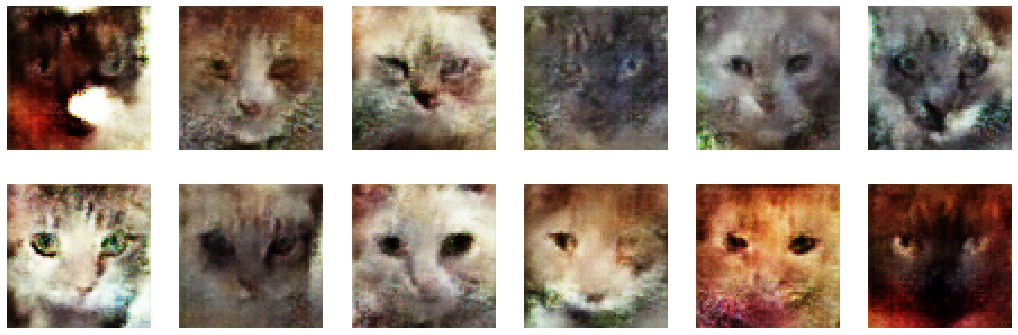

Last cycle time: 30.1
.....
Train step: 65


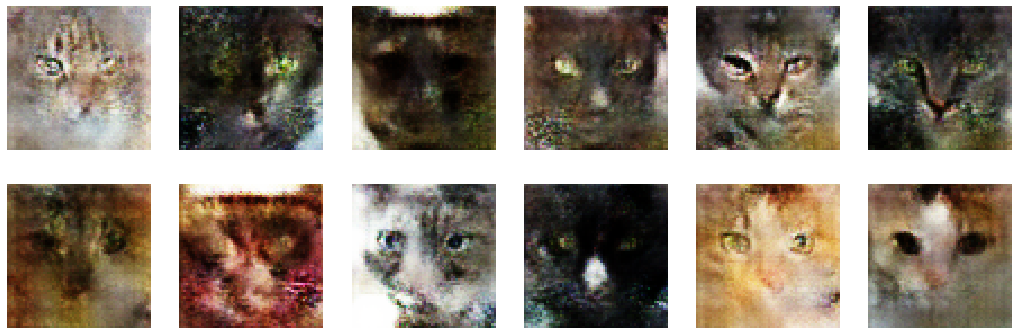

Last cycle time: 30.2
.....
Train step: 70


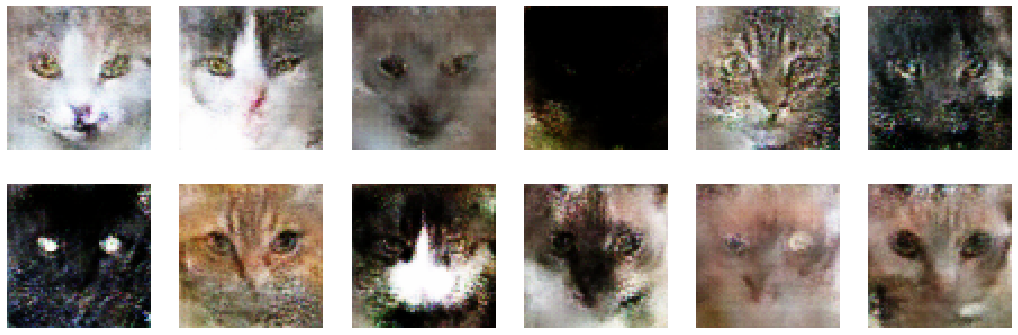

Last cycle time: 30.2
.....
Train step: 75


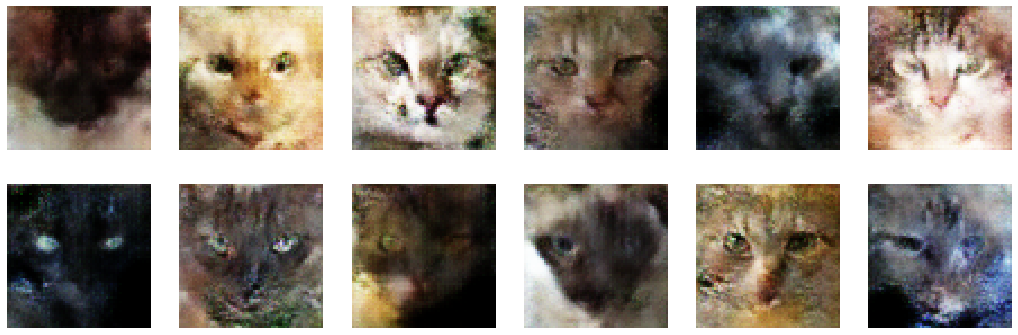

Last cycle time: 30.1
.....
Train step: 80


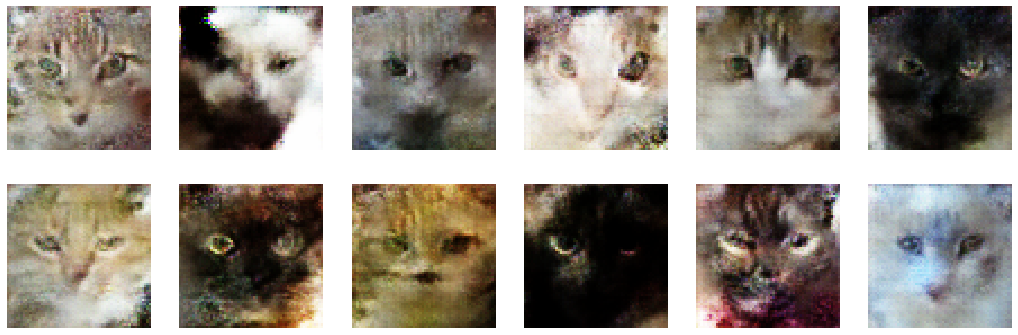

Last cycle time: 30.1
.....
Train step: 85


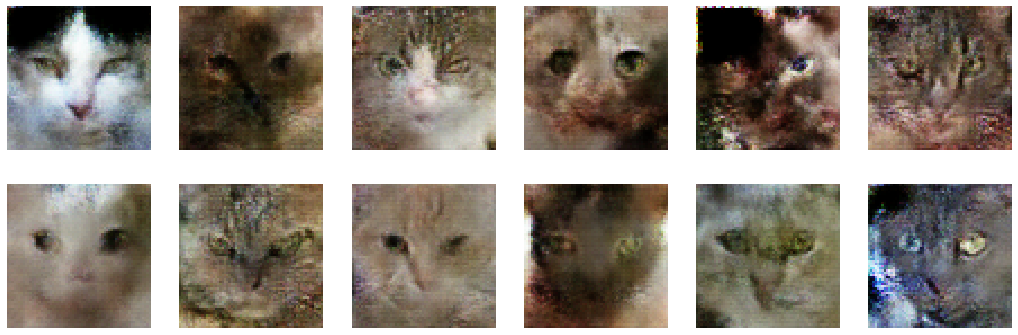

Last cycle time: 30.1
.....
Train step: 90


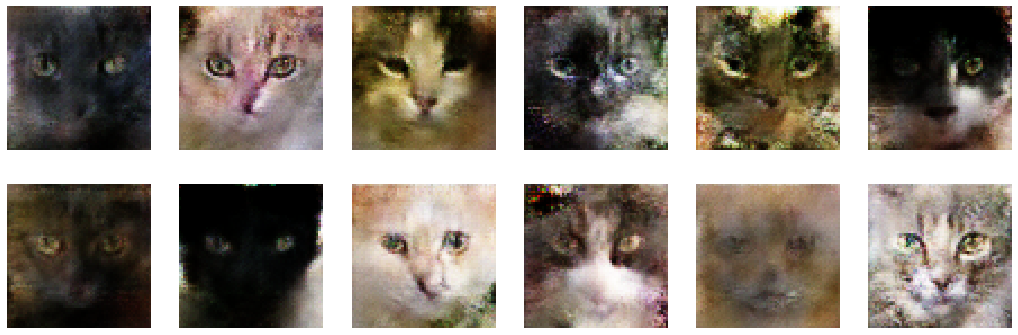

Last cycle time: 30.2
.....
Train step: 95


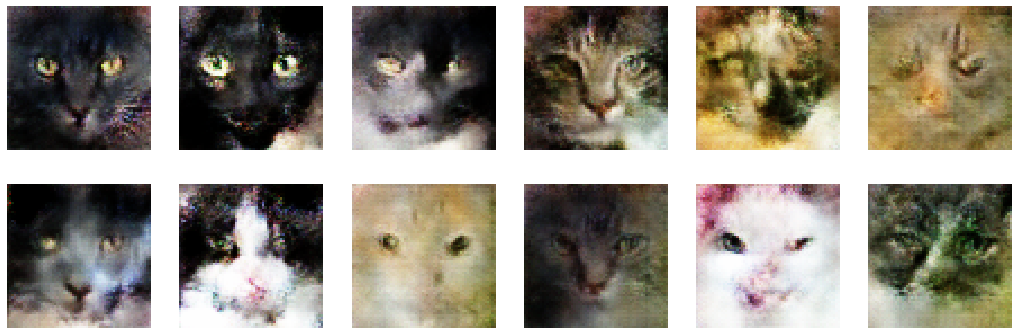

Last cycle time: 30.3
.....
Train step: 100


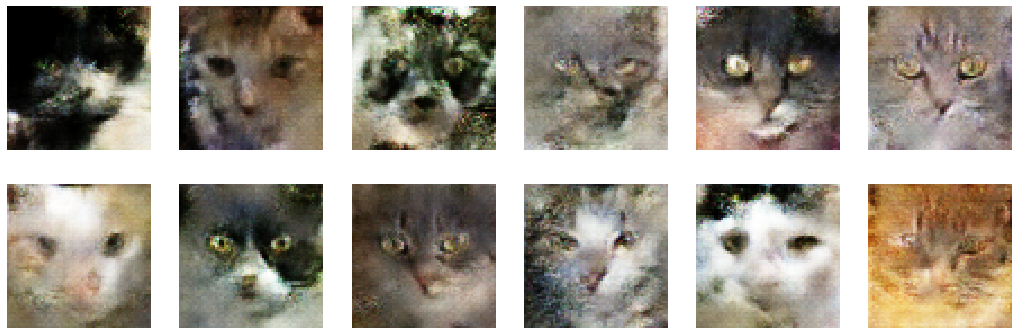

Last cycle time: 30.2
Total time: 620.9


In [43]:
train_gan(gan, sample_dataset, BATCH_SIZE, CODINGS_SIZE, EPOCHS)

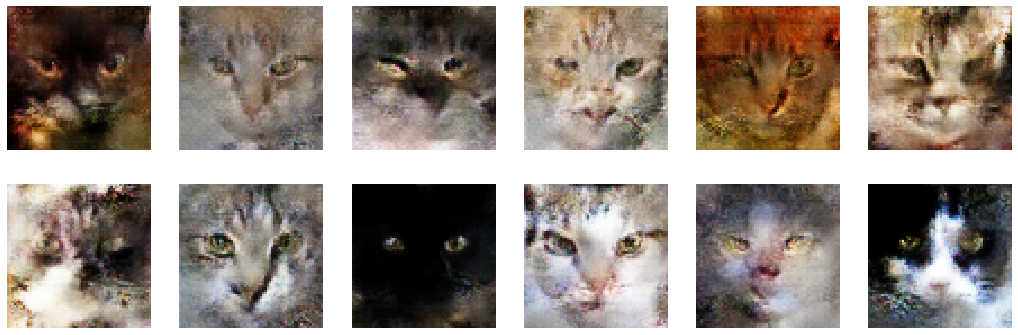

In [44]:
generated_images = generator(tf.random.normal(shape=[BATCH_SIZE, CODINGS_SIZE]))
plot_images(generated_images, 2, 6)

In [45]:
generated_images.shape

TensorShape([64, 64, 64, 3])

In [46]:
sample_dataset.take(1)

<TakeDataset shapes: (64, 64, 64, 3), types: tf.float32>

## ***The End***